In [ ]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

<ipython-input-2-b00b07bf67a6>:40: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  tpu_backend = xla_bridge.get_backend('tpu')
<ipython-input-2-b00b07bf67a6>:51: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  gpu_backend = xla_bridge.get_backend('gpu')


Set platform to GPU


# Prepare the Dataset

For the rescaled image matrix $M$, the "Hermitian version" of it can be calculated as:

$$
A = \frac{M+M^T}{2}
$$

In [ ]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.squeeze(x)),
    #torchvision.transforms.Lambda(lambda x: x / torch.trace(x)),
    torchvision.transforms.Lambda(lambda x: (x+torch.transpose(x, 0, 1))/2)
])

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print('labels:',dummy_y)
print(dummy_x[0,16])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8988375.14it/s] 


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 298042.98it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3192938.21it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4555363.17it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

(64, 32, 32)
(64,)
labels: [2 2 2 4 4 8 7 4 6 5 3 7 4 9 7 1 7 8 4 9 2 9 8 7 9 0 8 8 2 0 8 8 1 7 6 1 7
 3 7 9 1 6 6 8 2 6 9 7 5 7 4 0 0 6 7 0 3 4 0 6 9 2 1 7]
[0.         0.         0.         0.         0.         0.
 0.         0.31176472 0.6862745  0.6333333  0.05686275 0.
 0.         0.         0.         0.         0.         0.10392157
 0.49411765 0.49803922 0.54901963 0.87058824 0.4764706  0.21176471
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


# Time-Evolve the Image Hermitian

In [ ]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==32 and img.shape[-2] == 32, f"The shape of the image must be 32 by 32, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        dummy_x[0],
        10
        )[16]
    )


print('woooo')


print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        ))),
        img_hermitian_evolve(
        dummy_x[0],
        10
        )
    )
)
print("2nd")

print(
    jnp.einsum(
        "ij,jk->ik",
        img_hermitian_evolve(
        dummy_x[0],
        10
        ),
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        )))
    )
)

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.03462313+0.06695083j  0.00124743+0.346505j   -0.13502674-0.12334458j
  0.04290402+0.01991634j  0.05366695+0.04475433j -0.11126886-0.3577802j
  0.08616096-0.09633694j -0.02830324+0.12396277j -0.02518963-0.23937401j
 -0.21601929-0.24080105j  0.3113871 -0.26679683j -0.17762299-0.24793838j
 -0.00941812+0.15355514j  0.13265657-0.16094649j  0.02756487+0.05524293j
 -0.25922158-0.03666836j  0.09857541+0.16519293j  0.13651171+0.05740305j
  0.0732789 -0.17651679j  0.03928612-0.01207161j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
woooo
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.

# Some Utilities

In [ ]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])  #returning tensor product of I matrix of all n qubits

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2]) #tensor products of pauli gates, e.g XX, XY, XI, 4x4

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])  #tensor products of pauli gates, e.g XXX, XYY, XIZ, 8x8



pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )  #tensor products of pauli gates, e.g XXZX, XIZY, XZXI, 16x16



pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            ) #tensor products of pauli gates, e.g XXZZX, XIZYZ, XZZXI, 32x32



observables_10_cls_5q = [0]*10
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <10:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]]) #16x1
          four_qubit_obs = jnp.outer(basis_state, basis_state) #16x16
          observables_10_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1)) #32x32 matrix stored, up to 1001

observables_8_cls_5q = [0]*8
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <8:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_8_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))#32x32 matrix stored, up to 0111


In [ ]:
def su32_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk - >jk", params, jnp.asarray(list(pauli_words_su32.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[4**5-1], key=jrng_key) #random initialization, could try beta.


print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(su32_op(test_params))),
        su32_op(test_params)
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        su32_op(test_params),
        jnp.transpose(jnp.conjugate(su32_op(test_params)))
    )
)

In [ ]:
#observe which gates affect params the most
import jax.numpy as jnp


# Assume params is your parameter array and pauli_words_su32 is your gate mapping
def analyze_gates(params, pauli_words):
    # Filter non-zero coefficients and their corresponding gates
    non_zero_indices = jnp.nonzero(params)[0]
    influential_gates = {list(pauli_words.keys())[i]: params[i] for i in non_zero_indices}

    # Sort gates by absolute value of their coefficients
    sorted_gates = sorted(influential_gates.items(), key=lambda x: abs(x[1]), reverse=True)

    # Print influential gates and their coefficients
    for gate, coeff in sorted_gates:
        print(f"Gate: {gate}, Coefficient: {coeff}")

# Example usage
analyze_gates(test_params, pauli_words_su32)


In [ ]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)

# The QNN

With data re-uploading

$$
|{\varphi(\theta,t)}\rangle = \Pi_n (\mathrm{ParameterisedLayers}(\theta_n) e^{-\frac{it_n}{2}M} )|+\rangle^{\otimes 5}
$$

In [ ]:
def qnn_hamevo(
    params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A QNN that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for trainable layers
  and output an array of 2 elements representing classification logits
  """
  single_op_params = 4**5-1

  n_outer_layers = len(t)
  n_inner_layers = (len(params)//single_op_params)//n_outer_layers
  state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])
  for i in range(n_outer_layers):
    state = jnp.dot(
      img_hermitian_evolve(img, t[i]),
      state
      )
    inner_layer_params = params[i*(single_op_params*n_inner_layers):(i+1)*(single_op_params*n_inner_layers)]
    for j in range(n_inner_layers):
      state = jnp.dot(
          #brickwall_su4_5q_single_layer(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          su32_op(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          state
      )

  print('measure',vmap_measure_sv(state, jnp.asarray(observables_8_cls_5q)))
  return vmap_measure_sv(state, jnp.asarray(observables_8_cls_5q))



print(
    qnn_hamevo(
        jax.random.normal(shape=[( 4**5-1)*15], key=jrng_key),
        jax.random.normal(shape=[15], key=jrng_key),
        dummy_x[0]
    )
)

measure [0.09569074 0.03278066 0.03531775 0.05758628 0.0321305  0.0718443
 0.08542541 0.0519666 ]
[0.09569074 0.03278066 0.03531775 0.05758628 0.0321305  0.0718443
 0.08542541 0.0519666 ]


# Training

In [ ]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    out = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(out, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [ ]:
N_OUTER_LAYERS = 10
N_INNER_LAYERS = 1
N_LAYERS = N_OUTER_LAYERS*N_INNER_LAYERS
SINGLE_OP_PARAMS  = 4**5-1

# def init_weights():
#     return jax.random.normal(shape=[SINGLE_OP_PARAMS*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_OUTER_LAYERS], key=jrng_key)

def init_weights(alpha=0.5, beta=2.0):
    # Initialize weights with a Beta distribution skewed towards 0
    weights = jax.random.beta(jrng_key, alpha, beta, shape=[SINGLE_OP_PARAMS*N_LAYERS])
    biases = jax.random.beta(jrng_key, alpha, beta, shape=[N_OUTER_LAYERS])
    return weights, biases



In [ ]:
import numpy as np

def save_trained_params(weights, weights_last, filename='trained_params.npz'):
    np.savez(filename, weights=weights, weights_last=weights_last)
    print(f"Trained parameters saved to {filename}")


In [ ]:
# select data
import random
labels = [0,1,2,3,4,5,6,7]
indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

N_TRAIN = len(indices_train)
N_TEST = len(indices_test)

# Define the maximum number of samples you want for training and testing
max_train_samples = 10000  # Adjust this number as needed
max_test_samples = 2000    # Adjust this number as needed

# Randomly sample the indices
indices_train = random.sample(indices_train, min(len(indices_train), max_train_samples))
indices_test = random.sample(indices_test, min(len(indices_test), max_test_samples))

N_TRAIN = len(indices_train)
N_TEST = len(indices_test)

print(
    f"Training with: {N_TRAIN}; Testing with: {N_TEST}"
)
def train_vqc(batchsize:int, n_epochs:int, seed:int=1701):
  start = time.time()
  pnp.random.seed(seed)
  np.random.seed(seed)
  # load data
  labels = [0,1,2,3,4,5,6,7]
  indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
  indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]
  trainloader = torch.utils.data.DataLoader(
  torch.utils.data.Subset(train_dataset, indices_train), batch_size=batchsize, shuffle=True
)
  testloader = torch.utils.data.DataLoader(
  torch.utils.data.Subset(test_dataset, indices_test), batch_size=batchsize, shuffle=True
)
  # Exponential decay of the learning rate.
  scheduler = optax.exponential_decay(
    init_value=0.01,
    transition_steps=n_epochs,
    decay_rate=0.99)

  # Combining gradient transforms using `optax.chain`.
  gradient_transform = optax.chain(
    optax.clip(1.0),
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
  )
  # init weights and optimizer
  # weights, weights_last = init_weights() for normal
  weights, weights_last = init_weights(0.5,2.0)

  opt_state = gradient_transform.init((weights, weights_last))
  #data containers
  train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []
  for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        test_cost_batches = []
        test_acc_batches = []
        epoch_start = time.time()
        print(f"Training at Epoch {step+1}/{n_epochs}, Train batches {len(trainloader)}, Test batches {len(testloader)}......")
        for batch, (x_train, y_train) in enumerate(trainloader):
          batch_start = time.time()
          # Training step with (adam) optimizer
          x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
          train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
          updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
          weights, weights_last = optax.apply_updates((weights, weights_last), updates)
          train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
          train_cost_batches.append(train_cost)
          train_acc_batches.append(train_acc)
          if len(trainloader)<= 5 or (batch+1)%5==0:
            print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {train_cost}, Acc {train_acc}. Time {time.time()-batch_start}")


        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))


        # load test data
        for batch, (x_test, y_test) in enumerate(testloader):
          batch_start = time.time()
          x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
          # compute accuracy and cost on testing data
          test_out = compute_out(weights, weights_last, x_test, y_test)
          test_pred = jnp.argmax(test_out, axis=1)
          test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
          test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
          test_cost_batches.append(test_cost)
          test_acc_batches.append(test_acc)
          if len(testloader)<= 5 or (batch+1)%5==0:
            print(f"Testing at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {test_cost}, Acc {test_acc}. Time {time.time()-batch_start}")
        test_acc_epochs.append(np.mean(test_acc_batches))
        test_cost = np.mean(test_cost_batches)
        test_cost_epochs.append(test_cost)
        print("......")
        print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step+1}/{n_epochs}, Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
        print("=-="*10)
        save_trained_params(weights, weights_last)

  return dict(
        n_train=[N_TRAIN] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        test_cost=[c.astype(float) for c in test_cost_epochs],
        test_acc=[c.astype(float) for c in test_acc_epochs],
    )

Training with: 10000; Testing with: 2000


In [ ]:
n_epochs = 100
n_reps = 1
batch_size = 500

train_sizes = [N_TRAIN]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_vqc(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Training at Epoch 1/100, Train batches 97, Test batches 17......
measure Traced<ShapedArray(float64[8])>with<BatchTrace(level=5/0)> with
  val = Traced<ShapedArray(float64[500,8])>with<DynamicJaxprTrace(level=4/0)>
  batch_dim = 0


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2854: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Training at Epoch 1/100, Batch 5, Cost 2.0620692296206022, Acc 0.404. Time 1.3466641902923584
Training at Epoch 1/100, Batch 10, Cost 1.9517208786457658, Acc 0.532. Time 1.3409137725830078
Training at Epoch 1/100, Batch 15, Cost 1.8984618049308022, Acc 0.614. Time 1.3418612480163574
Training at Epoch 1/100, Batch 20, Cost 1.832373370910746, Acc 0.7. Time 1.3467483520507812
Training at Epoch 1/100, Batch 25, Cost 1.8212492318444153, Acc 0.702. Time 1.3412487506866455
Training at Epoch 1/100, Batch 30, Cost 1.7886644520202335, Acc 0.728. Time 1.3405468463897705
Training at Epoch 1/100, Batch 35, Cost 1.7752269625441564, Acc 0.778. Time 1.3389101028442383
Training at Epoch 1/100, Batch 40, Cost 1.7763993846904271, Acc 0.75. Time 1.3564224243164062
Training at Epoch 1/100, Batch 45, Cost 1.7398649839119706, Acc 0.8. Time 1.3469798564910889
Training at Epoch 1/100, Batch 50, Cost 1.7352361203823796, Acc 0.784. Time 1.3573212623596191
Training at Epoch 1/100, Batch 55, Cost 1.718715670280546

/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2854: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Testing at Epoch 1/100, Batch 5, Cost 1.6859805976829776, Acc 0.834. Time 0.3397705554962158
Testing at Epoch 1/100, Batch 10, Cost 1.6902344890919099, Acc 0.82. Time 0.34020328521728516
Testing at Epoch 1/100, Batch 15, Cost 1.685269563524967, Acc 0.814. Time 0.3437776565551758
measure Traced<ShapedArray(float64[8])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[17,8])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
......
Epoch 1/100, Train: Cost 1.773094594945248, Acc 0.7405876288659794
Epoch 1/100, Test: Cost 1.675540913579595, Acc 0.9411764705882353. Time 256.20639514923096
=-==-==-==-==-==-==-==-==-==-=
Trained parameters saved to trained_params.npz
Training at Epoch 2/100, Train batches 97, Test batches 17......
Training at Epoch 2/100, Batch 5, Cost 1.6664107864416182, Acc 0.85. Time 1.3648273944854736
Training at Epoch 2/100, Batch 10, Cost 1.6844603940389984, Acc 0.84. Time 1.3661479949951172
Training at Epoch 2/100, Batch 15, Cost 1.6501136265448464, 

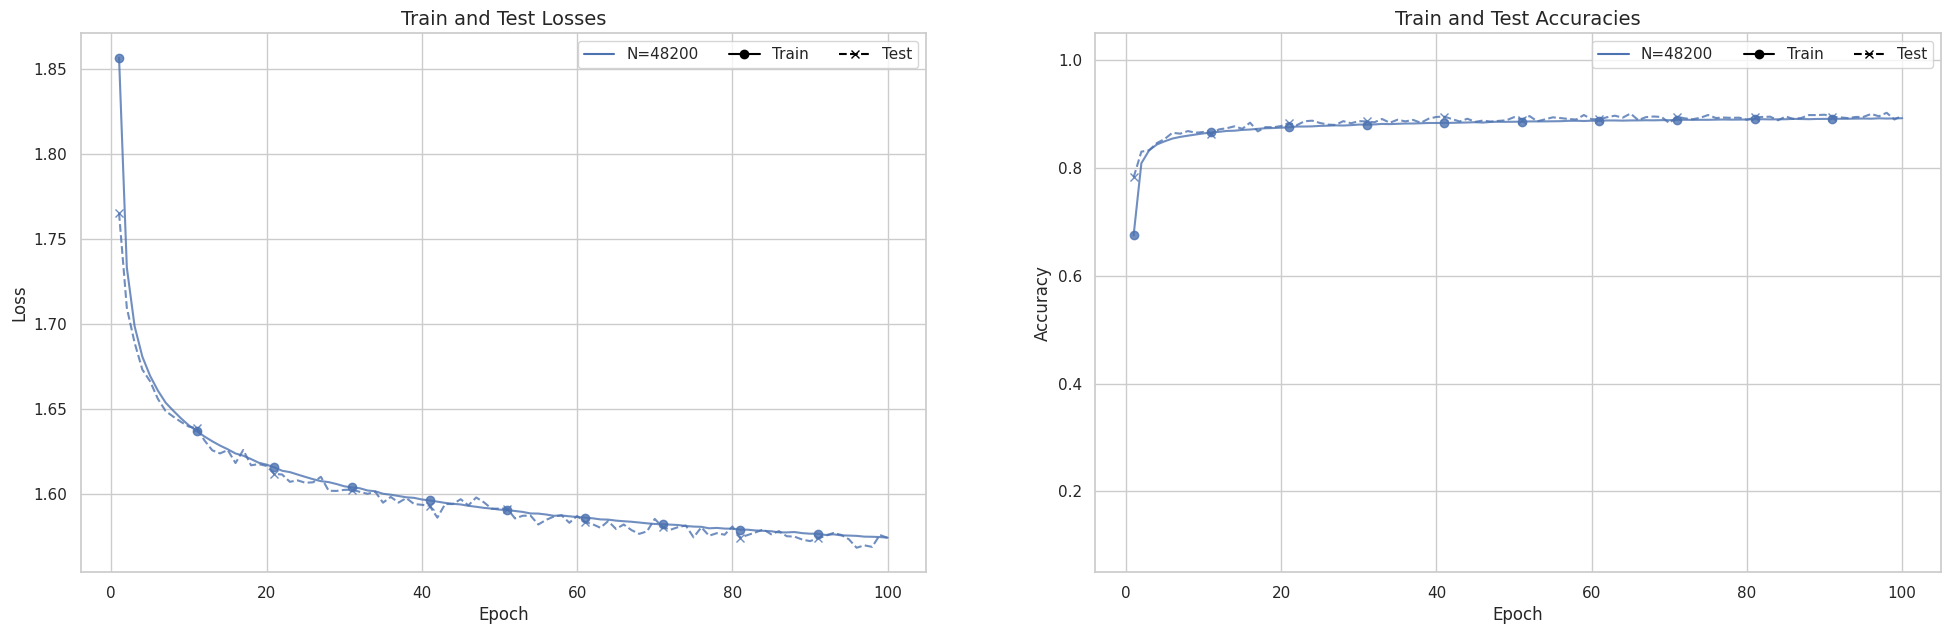

In [ ]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(24, 7))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    #dif = df[df.step == n_epochs].test_cost["mean"] - df[df.step == n_epochs].train_cost["mean"]
    #generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
#ax = axes[1]
#ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
#ax.set_xscale('log')
#ax.set_xticks(train_sizes)
#ax.set_xticklabels(train_sizes)
#ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
#ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [ ]:
import jax
import jax.numpy as jnp

# Assuming you have a trained set of parameters 'trained_params'
# and the dictionary 'pauli_words_su32' that maps Pauli word strings to matrices

def decompose_su32_operator(params, pauli_words_su32):
    """
    Decompose the su32 operator into a series of gates based on the trained parameters.
    """
    # Pauli word keys
    pauli_keys = list(pauli_words_su32.keys())

    # Initialize a list to hold the gate decomposition
    gate_decomposition = []

    # Go through each parameter and corresponding Pauli word
    for i, param in enumerate(params):
        # Get the corresponding Pauli word matrix from the dictionary
        pauli_word_matrix = pauli_words_su32[pauli_keys[i]]

        # Determine which Pauli word (like 'X', 'Y', 'Z', etc.) this corresponds to
        pauli_word = pauli_keys[i]

        # If the parameter is significant (not near zero), log it as a gate
        if jnp.abs(param) > 1e-6:  # Threshold for significance
            gate_info = {
                'pauli_word': pauli_word,
                'rotation_angle': param
            }
            gate_decomposition.append(gate_info)

    return gate_decomposition

# Example usage:
# Suppose you have trained parameters called `trained_params` and the `pauli_words_su32`
# dictionary is already built as part of your quantum neural network code.
trained_params = jax.random.normal(jax.random.PRNGKey(0), shape=(1023,))  # Replace with actual trained params
gate_decomposition = decompose_su32_operator(trained_params, pauli_words_su32)

# Print out the gate decomposition
for gate in gate_decomposition:
    print(f"Gate: {gate['pauli_word']}, Rotation Angle: {gate['rotation_angle']:.4f}")


In [ ]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/mnist"
results_df.to_csv(os.path.join(save_folder, "mnist_HermImgReUpload_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "mnist_HermImgReUpload_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "mnist_HermImgReUpload_results.png"))